In [1]:
import numpy as np
import random

from utils.blackjack_env_builder import BlackJackStylised
from utils.scorer import Scorer, quadratic_scorer
from tqdm import tqdm
from matplotlib import pyplot as plt
from utils.general import plot_Q_values

In [30]:
import numpy as np
import random

class BlackjackQLearningAgent:
    def __init__(self, num_states, num_deck_features, num_actions, learning_rate=0.1, discount_factor=0.9, epsilon=0.1):
        self.Q = np.zeros((num_states, 2, num_deck_features, num_actions))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.num_actions = num_actions

    def choose_action(self, state):
        current_sum, usable_ace, deck_feature = state
        if random.random() < self.epsilon:
            return random.choice(range(self.num_actions))
        else:
            return np.argmax(self.Q[int(current_sum), usable_ace, deck_feature])

    def update(self, state, action, reward, next_state, done):
        current_sum, usable_ace, deck_feature = state
        next_sum, next_usable_ace, next_deck_feature = next_state

        old_value = self.Q[int(current_sum), usable_ace, deck_feature, action]
        # print(next_sum, next_usable_ace, next_deck_feature)
        next_max = np.max(self.Q[int(next_sum), next_usable_ace, next_deck_feature]) if not done else 0

        new_value = old_value + self.learning_rate * (reward + self.discount_factor * next_max - old_value)
        self.Q[int(current_sum), usable_ace, deck_feature, action] = new_value

def get_deck_feature(card_counter):
    running_count = 0
    for card, info in card_counter.items():
        if card in ['2', '3', '4', '5', '6']:
            running_count += info['curr_count']
        elif card in ['10', 'J', 'Q', 'K', 'A']:
            running_count -= info['curr_count']

    if running_count <= -20:
        return 0  # Low count
    elif running_count <= 0:
        return 1  # Neutral
    else:
        return 2  # High count



In [64]:
# Example usage
num_states = 22  # 1 to 21 for card sum, and an additional state for bust
num_deck_features = 3  # Categories: Low, Neutral, High
num_actions = 2  # Actions: 0 for stick, 1 for hit
agent = BlackjackQLearningAgent(num_states, num_deck_features, num_actions, epsilon=0.25)

# Assuming you have an instance of your environment
env = BlackJackStylised(num_decks=2)
cards, current_sum, usable_ace, hand_complete = env.reset_init(hard=True)

for episode in tqdm(range(100000000)):
    deck_feature = get_deck_feature(env.card_counter)
    state = (int(current_sum-1), int(usable_ace), deck_feature)
    done = hand_complete

    while not done:
        action = agent.choose_action(state)
        next_cards, next_sum, next_usable_ace, hand_complete = env.step(action)
        next_deck_feature = get_deck_feature(env.card_counter)
        next_state = (next_sum, int(next_usable_ace), next_deck_feature)
        # reward = -1 if next_sum > 21 else 0  # Define your reward strategy
        reward = quadratic_scorer(next_sum)
        agent.update(state, action, reward, next_state, hand_complete)
        state = next_state
        done = hand_complete
        
    cards, current_sum, usable_ace, hand_complete = env.reset_init()


100%|████████████████████████████████████████████████████████████████| 100000000/100000000 [12:56<00:00, 128738.10it/s]


In [53]:
agent.Q

array([[[[  0.        ,   0.        ],
         [  0.        ,   0.        ],
         [  0.        ,   0.        ]],

        [[  0.        ,   0.        ],
         [  0.        ,   0.        ],
         [  0.        ,   0.        ]]],


       [[[  0.        ,   0.        ],
         [  0.76      ,   0.        ],
         [  0.76      ,   0.        ]],

        [[  0.        ,   0.        ],
         [  0.        ,   0.        ],
         [  0.        ,   0.        ]]],


       [[[  0.        ,   0.        ],
         [  0.9       ,   4.041     ],
         [  3.0951    ,   0.        ]],

        [[  0.        ,   0.        ],
         [  0.        ,   0.        ],
         [  0.        ,   0.        ]]],


       [[[  0.        ,   0.        ],
         [  1.6       ,  22.9216    ],
         [  4.336     ,   0.        ]],

        [[  0.        ,   0.        ],
         [  0.        ,   0.        ],
         [  0.        ,   0.        ]]],


       [[[  0.        ,   0.        ],
 

In [65]:
agent.Q[state[0], state[1], state[2]]

array([1.6, 1.6])

In [61]:
import matplotlib.pyplot as plt

def plot_q_values(agent, usable_ace, deck_feature_representative=0):
    x = range(1, 22)  # Assuming current_sum ranges from 1 to 21

    q_stick = [agent.Q[sum_val - 1, int(usable_ace), deck_feature_representative, 0] for sum_val in x]
    q_hit = [agent.Q[sum_val - 1, int(usable_ace), deck_feature_representative, 1] for sum_val in x]

    fig, ax = plt.subplots()

    bar_width = 0.35
    bar_stick = [i - bar_width / 2 for i in x]
    bar_hit = [i + bar_width / 2 for i in x]

    ax.bar(bar_stick, q_stick, bar_width, label='Stick')
    ax.bar(bar_hit, q_hit, bar_width, label='Hit')

    ax.set_xlabel('Current Sum')
    ax.set_ylabel('Q-Value')
    ax.set_title('Q-values with Usable Ace' if usable_ace else 'Q-values with Unusable Ace')
    ax.set_xticks(x)
    ax.set_xticklabels(x)
    ax.legend()

    plt.show()

# Example usage with your agent
# plot_q_values(your_agent, usable_ace=True, deck_feature_representative=0)  # For usable ace
# plot_q_values(your_agent, usable_ace=False, deck_feature_representative=0) # For unusable ace


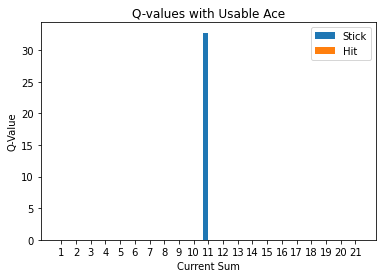

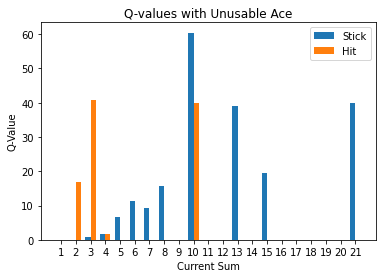

In [66]:
plot_q_values(agent, usable_ace=True, deck_feature_representative=1)  # For usable ace
plot_q_values(agent, usable_ace=False, deck_feature_representative=1) # For unusable ace

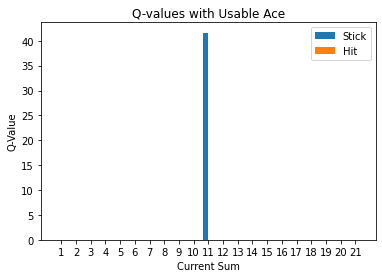

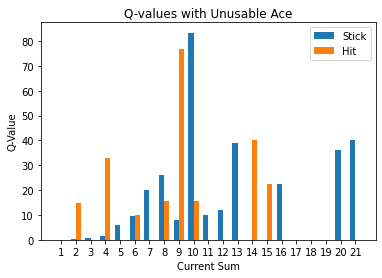

In [67]:
plot_q_values(agent, usable_ace=True, deck_feature_representative=2)  # For usable ace
plot_q_values(agent, usable_ace=False, deck_feature_representative=2) # For unusable ace

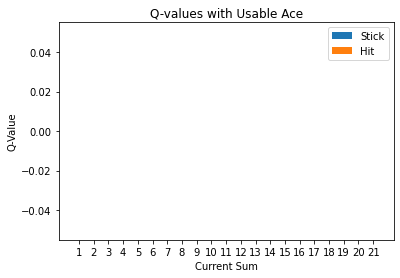

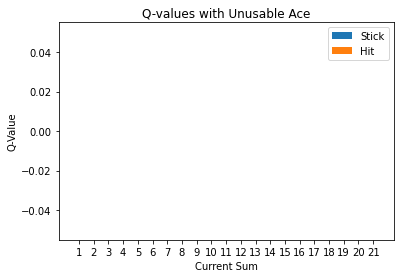

In [68]:
plot_q_values(agent, usable_ace=True, deck_feature_representative=0)  # For usable ace
plot_q_values(agent, usable_ace=False, deck_feature_representative=0) # For unusable ace

In [ ]:
plot_q_values(agent, usable_ace=True, deck_feature_representative=1)  # For usable ace
plot_q_values(agent, usable_ace=False, deck_feature_representative=1) # For unusable ace

In [69]:
agent.Q.shape

(22, 2, 3, 2)